In [3]:
import uproot, vector, awkward as ak, numpy as np

filename="user.tapark.41935082._000001.tree.root"
file = uproot.open(filename)
tree = file["JetConstituentTree"]
# tree.show()
# to read TBranch ; NOTE: use entry_start, entry_stop to read only specific amounts of entry for optimization
tjets = tree.arrays(['truthJet_pt', 'truthJet_eta', 'truthJet_phi', 'truthJet_m', 'event_weight'], library="np")
# add filtering on truth jets: cut="truthJet_m >= 20000"
reco_jets = tree.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_m'], library="np")


In [39]:
# filter M = 20 GeV truth jets
# m20gev_tjets = [ event for event in truth_jets['truthJet_m'] if any(y>=20000 for y in event) ]
# m20gev_tjets

[]

In [127]:
# import numpy as np
# import awkward as ak
# import time

# # SETUP DATA HERE

# truth_jets_pt = [ event for event in tjets["truthJet_pt"] if len(event)!=0 ]
# truth_jets_phi = [ event for event in tjets["truthJet_phi"] if len(event)!=0 ]
# truth_jets_eta = [ event for event in tjets["truthJet_eta"] if len(event)!=0 ]
# truth_jets_m = [ event for event in tjets["truthJet_m"] if len(event)!=0 ]

# data_time_s = time.time()
# tjets_pt_ak = ak.Array(truth_jets_pt)
# tjets_phi_ak = ak.Array(truth_jets_phi)
# tjets_eta_ak = ak.Array(truth_jets_eta)
# tjets_m_ak = ak.Array(truth_jets_m)
# zipd_t = ak.zip({"pt": tjets_pt_ak, "phi": tjets_phi_ak, "eta": tjets_eta_ak, "m": tjets_m_ak})

# rjets_pt_ak = ak.Array(reco_jets["jet_pt"].tolist())
# rjets_phi_ak = ak.Array(reco_jets["jet_phi"].tolist())
# rjets_eta_ak = ak.Array(reco_jets["jet_eta"].tolist())
# rjets_m_ak = ak.Array(reco_jets["jet_m"].tolist())
# zipd_r = ak.zip({"pt": rjets_pt_ak, "phi": rjets_phi_ak, "eta": rjets_eta_ak, "m": rjets_m_ak})

# data_time_e = time.time()
# print(f"{data_time_e-data_time_s:.2f} seconds for data")

117.54 seconds for data


In [104]:
# from multiprocessing import Process, Queue

# def compute_momentum(row):
#     data_pt = row["pt"]
#     data_phi = row["phi"]
#     data_eta = row["eta"]
#     data_m = row["m"]
#     return vector.MomentumObject4D(pt=data_pt, phi=data_phi, eta=data_eta, m=data_m)

# def main(data, output_queue):
#     vfunc = np.vectorize(compute_momentum)
#     print("Momentum4DObjects runnning...")
#     Momentum4DObjects = [[vfunc(entry) for entry in event] for event in data]
#     print("Momentum4DObjects finished")
#     output_queue.put(Momentum4DObjects)

# if __name__== '__main__':
#     start = time.time()
#     queue = Queue()
#     process1 = Process(target=main, args=(zipd_t,queue))
#     process2 = Process(target=main, args=(zipd_r,queue))

#     process1.start()
#     process2.start()

#     process1.join()
#     process2.join()
#     end = time.time()
#     print(f"{end-start:.2f} seconds for 4Momenta")
#     x = queue.get()
#     y = queue.get()
#     print(f"Truth Jet 4Momenta: {x}, Reco Jet 4Momenta: {y}")

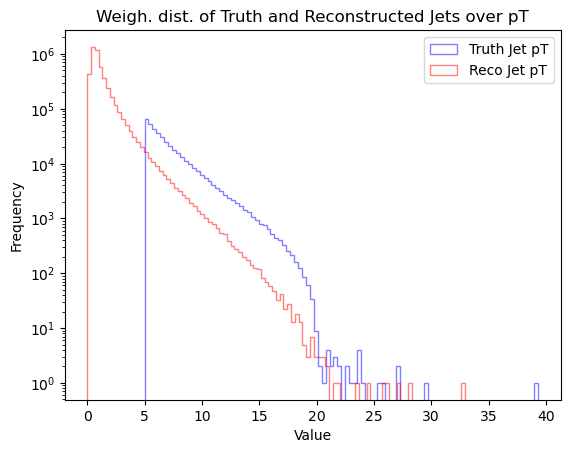

In [119]:
import matplotlib.pyplot as plt
import numpy as np

pts = ak.Array(tjets["truthJet_pt"].tolist())
weights = ak.Array(tjets["event_weight"].tolist())

data1 = ak.zip({"pt":pts/1000, "weight":weights})

ptsr = ak.Array(reco_jets["jet_pt"].tolist())
data1r = ak.zip({"pt":ptsr/1000, "weight":weights})

plt.hist(ak.flatten(data1)["pt"], weights=ak.flatten(data1)["weight"], alpha=0.5, bins=100, label="Truth Jet pT", color="blue", histtype="step")
plt.hist(ak.flatten(data1r)["pt"], weights=ak.flatten(data1r)["weight"], alpha=0.5, bins=100, label="Reco Jet pT", color="red", histtype="step")

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Weigh. dist. of Truth and Reconstructed Jets over pT")
plt.legend()
plt.show()

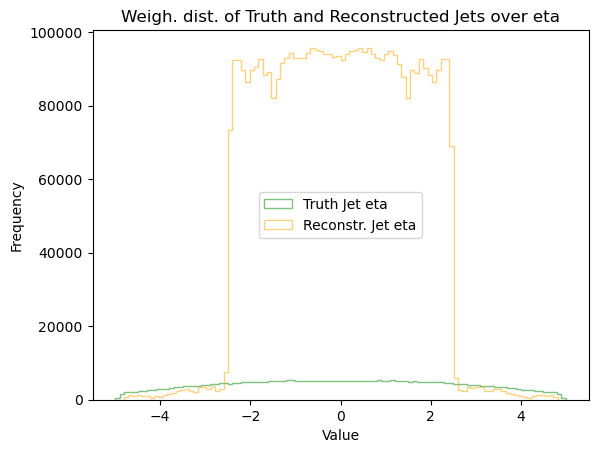

In [123]:
etas = ak.Array(tjets["truthJet_eta"].tolist())
data2 = ak.zip({"eta":etas, "weight":weights})
etasr = ak.Array(reco_jets["jet_eta"].tolist())
data2r = ak.zip({"eta":etasr, "weight":weights})

plt.hist(ak.flatten(data2)["eta"], weights=ak.flatten(data2)["weight"], alpha=0.5, bins=100, label="Truth Jet eta", color="green", histtype="step")
plt.hist(ak.flatten(data2r)["eta"], weights=ak.flatten(data2r)["weight"], alpha=0.5, bins=100, label="Reconstr. Jet eta", color="orange", histtype="step")


plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Weigh. dist. of Truth and Reconstructed Jets over eta")
plt.legend()
plt.show()

In [160]:
data_time_s = time.time()
tjets_pt_ak = ak.Array(tjets["truthJet_pt"].tolist())
tjets_phi_ak = ak.Array(tjets["truthJet_phi"].tolist())
tjets_eta_ak = ak.Array(tjets["truthJet_eta"].tolist())
tjets_m_ak = ak.Array(tjets["truthJet_m"].tolist())
zipd_t = ak.zip({"pt": tjets_pt_ak, "phi": tjets_phi_ak, "eta": tjets_eta_ak, "m": tjets_m_ak})

rjets_pt_ak = ak.Array(reco_jets["jet_pt"].tolist())
rjets_phi_ak = ak.Array(reco_jets["jet_phi"].tolist())
rjets_eta_ak = ak.Array(reco_jets["jet_eta"].tolist())
rjets_m_ak = ak.Array(reco_jets["jet_m"].tolist())
zipd_r = ak.zip({"pt": rjets_pt_ak, "phi": rjets_phi_ak, "eta": rjets_eta_ak, "m": rjets_m_ak})

data_time_e = time.time()
print(f"{data_time_e-data_time_s:.2f} seconds for data")

102.28 seconds for data


In [277]:
# zipd_t[0], zipd_r[0]

def construct_momentum(entry):
    return vector.MomentumObject4D(pt=entry["pt"] ,phi=entry["phi"], eta=entry["eta"], m=entry["m"])

def main(eventT, eventR):
    momentaT = [construct_momentum(x) for x in eventT]
    momentaR = [construct_momentum(x) for x in eventR]
    isReco = [ 1 for x in momentaT if 1 in [1 for y in momentaR if x.deltaR(y) < 0.4] ]
    return isReco

In [278]:
res = []
start = time.time()
print("Running matching...")
for x in range(len(zipd_t)):
    res.append(main(zipd_t[x], zipd_r[x]))
end = time.time()
print(f"{end-start:.2f} seconds for matching procedure")
res

Running matching...
689.62 for matching procedure


[[],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [],
 [],
 [1, 1],
 [1],
 [1],
 [],
 [],
 [],
 [],
 [],
 [],
 [1],
 [],
 [],
 [],
 [],
 [1, 1],
 [],
 [],
 [],
 [],
 [],
 [1],
 [1],
 [],
 [],
 [],
 [],
 [],
 [1],
 [],
 [1, 1, 1],
 [1],
 [1],
 [],
 [],
 [1],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [1],
 [1],
 [],
 [],
 [1, 1, 1, 1, 1, 1, 1, 1],
 [],
 [],
 [],
 [],
 [1],
 [],
 [1, 1],
 [],
 [1, 1, 1],
 [],
 [],
 [],
 [],
 [1],
 [],
 [],
 [],
 [],
 [],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [],
 [],
 [],
 [],
 [],
 [1, 1],
 [],
 [1],
 [1, 1],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [1],
 [],
 [],
 [],
 [1],
 [],
 [1, 1],
 [],
 [],
 [],
 [],
 [1],
 [],
 [],
 [1, 1],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [1],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [1, 1, 1, 1, 1, 1],
 [],
 [],
 [],
 [],
 [],
 [1, 1],
 [],
 [],
 [],
 [],
 [1],
 [1],
 [],
 [],
 [],
 [1],
 [],
 [1, 1, 1

In [286]:
truthJetXIsRecoIndeces = [i for i,x in enumerate(res) if len(x)!=0]
truthJetXIsRecoIndeces
truthJetXIsReco = [tjets["truthJet_pt"][x] for x in truthJetXIsRecoIndeces]